### Libraries

In [127]:
import pandas as pd
import numpy as np
import gc
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
os.chdir('//mbip\medicarepBI\Projects\COE\Retention\Data\Churn V2'.replace("\\",'/'))

pd.set_option('max_columns',None)
pd.set_option('max_rows',None)

### Function to get Decile Analysis

In [128]:
def decile(estimator,X,Y):
    full_file_x = X.copy()
    full_file_y = Y.copy()
    full_file_x['Prob'] = estimator.predict_proba(full_file_x)[:,1]
    full_file_x['Deciles']= pd.qcut(full_file_x.Prob.rank(method='first'),q=10,labels=np.arange(10,0,-1),)
    
    full_file_x['Target'] = full_file_y.values
    k = full_file_x.groupby(['Deciles','Target']).size().unstack().fillna(0).rename(columns= {0:'Zero',1:'Ones'})
    k['Population'] = k['Ones']+k['Zero']
    summary=k.sort_index(ascending=False)
    summary['TargetRate']=summary['Ones']/summary['Population']
    summary['CumulativeTargetRate']=summary['Ones'].cumsum()/summary['Population'].cumsum()
    summary['TargetsCaptured']=summary['Ones'].cumsum()/summary['Ones'].sum()
    return summary

### Variables to use

In [129]:
# modified variable list 
use_vars=[
'SRC_MEMBER_ID',
'AgeinYrs',
'CAPITATION_AMT',
'DENIED_CLAIM_LINE_COUNT',
'MED_RISK_SCORE',
#'Pharm_Disr_Type',
'TOTAL_MED_COST',
'TOTAL_RX_COST',
'call_history',
# 'past_grv_count',
'HEPATITIS',
'CHRONIC_FATIGUE_SYNDROME',
'PERIPHERAL_ARTERY_DISEASE',
'PERIODONTAL_DISEASE',
'MEMBER_SUMMARY',
'CHRONIC_RENAL_FAILURE',
'LYME_DISEASE',
'OBESITY',
'CHRONIC_THYROID_DISORDERS',
'ALLERGY',
'SYSTEMIC_LUPUS_ERYTHEMATOSUS',
'BENIGN_PROSTATIC_HYPERTROPHY',
'KIDNEY_STONES',
'HYPERLIPIDEMIA',
'OTITIS_MEDIA',
'HYPERTENSION',
'HIV_OR_AIDS',
'DEMENTIA',
'DIABETES_MELLITUS',
'UNQ_ALL_PRVDR_PAR_PAID_AMT',
'UNQ_ALL_PRVDR_NONPAR_PAID_AMT',

#'TimeZone',
'NF_count',
#'ST_count',
#'PA_count',
'PC_count',
'TC_count',
'TOTAL_DENTAL_PROCEDURES_9MONTHS',
'TOTAL_LAB_PROCEDURES_9MONTHS',
'PCP_VISITS_COUNT',
'ER_VISITS_COUNT',
'IP_VISITS_COUNT',
'PHM_TOT_CLM_CNT',
'MED_TOT_CLM_CNT',
'GRV_ACCESS',
'GRV_APPEARANCE_OF_FACILITY',
'GRV_APPEARANCE_OF_SITE',
'GRV_BENEFIT_PACKAGE',
'GRV_BILLING',
'GRV_CMS_ISSUES',
'GRV_COVERAGE_DETERMINATION_REDETERMINATION',
'GRV_CUSTOMER_SERVICE',
'GRV_ENROLLMENT_DISENROLLMENT',
'GRV_MARKETING',
'GRV_MEMBER_MATERIALS',
'GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION',
'GRV_PLAN_BENEFITS',
'GRV_PRIVACY',
'GRV_PROVIDER_CUSTOMER_SERVICE',
'GRV_QUALITY_OF_CARE',
'GRV_TECHNOLOGY',
#'PlanType',
'Notional_InpatientStayMC',
'Notional_PhysicianSpecialist',
'Notional_Lab',
'Notional_DeductibleAnnual',
'Notional_MOOPINN',
'Notional_Premium',
'Notional_PCP',
'Notional_Emergency',
'Notional_UrgentlyNeededCare',
'Notional_RxDeductible',
#'Notional_2019_InpatientStayMC',
#'Notional_2019_PhysicianSpecialist',
#'Notional_2019_Lab',
#'Notional_2019_DeductibleAnnual',
#'Notional_2019_MOOPINN',
#'Notional_2019_Premium',
#'Notional_2019_PCP',
#'Notional_2019_Emergency',
#'Notional_2019_UrgentlyNeededCare',
#'Notional_2019_RxDeductible',
'HNG1_Flag',
'HNG2_Flag',
'Cancer',
'Mental_Disorders',
'Neural',
'Reproductive',
'Substance_Related_Disorders',
'Vision_Related_Disorders',
'Orthopedic',
'Lung_Related_Disorders',
'Heart_Related_Disorders',
'blood_Related_Disorders',
'Abdomen_Related_Disorders',
'UNQ_ALL_PRVDR_PAR_CLAIM_COUNT',
'UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT',
'SPCLST_TRANSACTIONS',
'MBR_Score18',
'DISTINCT_GPI',
#'FIPS',
#'COMPETITORS_PLN_CNT',
#'AETNA_PLN_CNT',
'COMPETITOR_CNT',
'AETNA_MRKT_SHARE_PCT',
#'AETNA_RANK',
#'DIFF_TOP_COMPETITOR',
#'AETNA_RELATIVE_RANK',
'AETNA_PLAN_RANK',
#'AETNA_PLN_MRKT_SHARE_PCT',
'Total_eligible_2018',
'Total_compliance_2018',
#'NROWS_TERM',
'SUM_CNT_PLAN_CHANGE',
'Market',
'SNP_IND',
# 'OEP_AEP',
'LIS_Ind',
#'TENURE_IN_YRS',
#'SUM_CNT_CNT_TOH_ID_CHANGE',
'YoY_Diff_RxDeductible',
'YoY_Diff_UrgentlyNeededCare',
#'NROWS_RAPID_TERM',
#   'MBR_TROOP_AMT',
#'SUM_CNT_WRITING_AGENT_CHANGE'
# 'NEWMAP_MARKET'
]


In [130]:
len(use_vars)

95

### Y2018

In [131]:
base = pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Churn V2/churnbase_merge_hpd_and_planbenefit2018_for_eda_19Jun2019.csv',
                   engine='c',
                  usecols = use_vars,
                  dtype={'SRC_MEMBER_ID':str})
#base.drop(base.columns[0],axis=1,inplace=True)
#base.head()
base.shape

(962312, 95)

In [132]:
## Adding Tenure
base_tenure = pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Ting/Data Dump 20200129/AEP_2019_DataDump.csv',usecols = ['Tenure_Aetna_Mths','Member_ID','NEW_MARKET','AEP2019_Lapse']).rename({'Tenure_Aetna_Mths':'TENURE_IN_YRS','Member_ID':'SRC_MEMBER_ID'},axis=1)
base_tenure.SRC_MEMBER_ID = base_tenure.SRC_MEMBER_ID.astype(str)
base_tenure.SRC_MEMBER_ID = base_tenure.SRC_MEMBER_ID.str.split('*').str.join('').str.strip()

In [133]:
base_tenure.head(4)

,AEP2019_Lapse,SRC_MEMBER_ID,TENURE_IN_YRS,NEW_MARKET
0,0,762053557012,9.0,CAPITOL
1,0,MEBN880Z,35.0,NEWENGLAND
2,0,MEBJ222P,43.0,CAPITOL
3,0,80461795801,23.0,FLORIDA


In [134]:
base = base.merge(base_tenure,on='SRC_MEMBER_ID',how='left')

In [135]:
base = base[base.TENURE_IN_YRS.notnull()]

In [136]:
base['TENURE_IN_YRS'] = np.clip(base['TENURE_IN_YRS'], a_max=120, a_min=None) #changed from 150 to 120

In [137]:
##Year Conversion (has changed as per Arindam)
#base.TENURE_IN_YRS = (base.TENURE_IN_YRS+1)/12
#base['TENURE_IN_YRS'] = np.clip(base['TENURE_IN_YRS'], a_max=12, a_min=None)

#### Subset Filter


In [138]:
base.Market.value_counts()

Keystone         155448
Heartland        116487
Florida           84098
Deep South        79201
Mid South         76938
Texas             74217
Ohio              52538
New York          52486
New Jersey        50331
Midlands          45303
ShowMe            39277
New England       36974
California        17517
North Capitol     16676
Great Lakes       15572
Nevada             8549
Northwest          8521
Arizona            5888
Utah               4017
Colorado           2135
Name: Market, dtype: int64

In [139]:
base.SNP_IND.value_counts(dropna = False)

N    922524
Y     19649
Name: SNP_IND, dtype: int64

In [140]:
data = base[(base.NEW_MARKET.isin(['SOUTHCENTRAL']))]# & (base.LIS_Ind == 'N')]
data = data[data.SNP_IND == 'N']
#data = data[data.OEP_AEP != 'OEP']
#data['UNQ_ALL_PRVDR_CLAIM_COUNT_PAR_NONPAR_RATIO'] = data['UNQ_ALL_PRVDR_PAR_CLAIM_COUNT']/data['UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT']
data.shape

(84375, 98)

### Processing The Source Member IDs

In [141]:
data.SRC_MEMBER_ID = data.SRC_MEMBER_ID.astype(str)
data.SRC_MEMBER_ID = data.SRC_MEMBER_ID.str.split('*').str.join('').str.strip()
data.SRC_MEMBER_ID = data.SRC_MEMBER_ID.str.strip()

### Reading the new Dependent variable

In [142]:
new_dv=pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Churn V2/New_DEPENDENT_VARIABLE_DV0611_WITH_IDs.csv',
                   dtype={"SRC_MEMBER_ID":str,
                         'INDIVIDUAL_ID':str} )
print(new_dv.shape)

(1051925, 3)


### Processing the Source Member IDs for new Dependent variables

In [143]:
new_dv.SRC_MEMBER_ID=new_dv.SRC_MEMBER_ID.astype(str)
new_dv.SRC_MEMBER_ID=new_dv.SRC_MEMBER_ID.str.split('*').str.join('').str.strip()
new_dv.SRC_MEMBER_ID = new_dv.SRC_MEMBER_ID.str.strip()

In [144]:
new_dv.INDIVIDUAL_ID=new_dv.INDIVIDUAL_ID.astype(str)
new_dv.INDIVIDUAL_ID = new_dv.INDIVIDUAL_ID.str.strip()

In [145]:
new_dv.head()

,SRC_MEMBER_ID,INDIVIDUAL_ID,DV0611
0,101039819500,9098741262731,0
1,101039821100,96596798578555,0
2,101039821200,6076692923007855,0
3,101039821300,18657948,0
4,101039821400,86568453016,0


### Merging the new Dependent variable in the Florida data frame

In [146]:
data=pd.merge(data,new_dv,on='SRC_MEMBER_ID',how='inner')
data.shape

(84028, 100)

### New Event Rate

In [147]:
data['AEP2019_Lapse'].value_counts(normalize=True)

0.0    0.904782
1.0    0.095218
Name: AEP2019_Lapse, dtype: float64

In [148]:
data['AEP2019_Lapse'].value_counts()

0.0    76027
1.0     8001
Name: AEP2019_Lapse, dtype: int64

### Taking nrows which are not null

### Summing Grivance Counts

In [149]:
data['grievances_total'] = data[['GRV_ACCESS','GRV_APPEARANCE_OF_FACILITY','GRV_APPEARANCE_OF_SITE','GRV_BENEFIT_PACKAGE','GRV_BILLING',
                                     'GRV_CMS_ISSUES','GRV_COVERAGE_DETERMINATION_REDETERMINATION','GRV_CUSTOMER_SERVICE','GRV_ENROLLMENT_DISENROLLMENT',
                                     'GRV_MARKETING','GRV_MEMBER_MATERIALS','GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION','GRV_PLAN_BENEFITS',
                                     'GRV_PRIVACY','GRV_PROVIDER_CUSTOMER_SERVICE','GRV_QUALITY_OF_CARE','GRV_TECHNOLOGY'
                                   ]].sum(axis=1)

# HEDIS Measures

In [150]:
measures = ['SRC_MEMBER_ID',
            'INDIVIDUAL_ID',
            'Flag_Adult BMI Assessment',
'Flag_Annual Flu Vaccine',
'Flag_Breast Cancer Screening',
'Flag_CHOL_ADHERENT_STATUS',
'Flag_Colorectal Cancer Screening',
'Flag_Controlling High Blood Pressure',
'Flag_DIAB_ADHERENT_STATUS',
'Flag_Diabetes Care - Blood Sugar Controlled',
'Flag_Diabetes Care - Eye Exams',
'Flag_Medication Reconciliation Post Discharge',
'Flag_RAS_ADHERENT_STATUS']

In [151]:
hedis = pd.read_csv('Final_training_dataset_2018_D06Nov2019_v2.csv',
                    usecols=measures,
                    dtype= {'SRC_MEMBER_ID':str,'INDIVIDUAL_ID':str},engine='c')

In [152]:
hedis.SRC_MEMBER_ID = hedis.SRC_MEMBER_ID.str.strip()
hedis.INDIVIDUAL_ID = hedis.INDIVIDUAL_ID.str.strip()

In [153]:
hedis.shape

(917460, 13)

In [154]:
data = pd.merge(data,hedis,left_on=['SRC_MEMBER_ID','INDIVIDUAL_ID'],right_on =['SRC_MEMBER_ID','INDIVIDUAL_ID'],how='left')

In [155]:
data['Compliance_Ratio'] =(data.Total_compliance_2018/data.Total_eligible_2018).fillna(0)

### Imputing NA values

In [156]:
data.select_dtypes(exclude='object').fillna(0,inplace = True)

C:\Users\n432209\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [157]:
for col in data.isnull().sum()[data.isnull().sum()>0].index:
    print(f'{col} & {data[col].mode()[0]}')
    data[col] =data[col].fillna(data[col].mode()[0])

Flag_Adult BMI Assessment & Not_Eligible
Flag_Annual Flu Vaccine & Eligible_and_complaint
Flag_Breast Cancer Screening & Not_Eligible
Flag_CHOL_ADHERENT_STATUS & Not_Eligible
Flag_Colorectal Cancer Screening & Not_Eligible
Flag_Controlling High Blood Pressure & Not_Eligible
Flag_DIAB_ADHERENT_STATUS & Not_Eligible
Flag_Diabetes Care - Blood Sugar Controlled & Not_Eligible
Flag_Diabetes Care - Eye Exams & Not_Eligible
Flag_Medication Reconciliation Post Discharge & Not_Eligible
Flag_RAS_ADHERENT_STATUS & Not_Eligible


In [158]:
data.shape

(84028, 113)

### Creating the Dependent variable and the feature set

#### Drop selected vars

In [159]:
data.head()

,SRC_MEMBER_ID,AgeinYrs,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,call_history,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,MEMBER_SUMMARY,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,Market,LIS_Ind,NF_count,PC_count,TC_count,SNP_IND,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,IP_VISITS_COUNT,PHM_TOT_CLM_CNT,MED_TOT_CLM_CNT,GRV_ACCESS,GRV_APPEARANCE_OF_FACILITY,GRV_APPEARANCE_OF_SITE,GRV_BENEFIT_PACKAGE,GRV_BILLING,GRV_CMS_ISSUES,GRV_COVERAGE_DETERMINATION_REDETERMINATION,GRV_CUSTOMER_SERVICE,GRV_ENROLLMENT_DISENROLLMENT,GRV_MARKETING,GRV_MEMBER_MATERIALS,GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION,GRV_PLAN_BENEFITS,GRV_PRIVACY,GRV_PROVIDER_CUSTOMER_SERVICE,GRV_QUALITY_OF_CARE,GRV_TECHNOLOGY,YoY_Diff_UrgentlyNeededCare,YoY_Diff_RxDeductible,Notional_InpatientStayMC,Notional_PhysicianSpecialist,Notional_Lab,Notional_DeductibleAnnual,Notional_MOOPINN,Notional_Premium,Notional_PCP,Notional_Emergency,Notional_UrgentlyNeededCare,Notional_RxDeductible,HNG1_Flag,HNG2_Flag,Cancer,Mental_Disorders,Neural,Reproductive,Substance_Related_Disorders,Vision_Related_Disorders,Orthopedic,Lung_Related_Disorders,Heart_Related_Disorders,blood_Related_Disorders,Abdomen_Related_Disorders,UNQ_ALL_PRVDR_PAR_CLAIM_COUNT,UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT,SPCLST_TRANSACTIONS,UNQ_ALL_PRVDR_PAR_PAID_AMT,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,MBR_Score18,DISTINCT_GPI,COMPETITOR_CNT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,Total_eligible_2018,Total_compliance_2018,SUM_CNT_PLAN_CHANGE,AEP2019_Lapse,TENURE_IN_YRS,NEW_MARKET,INDIVIDUAL_ID,DV0611,grievances_total,Flag_Adult BMI Assessment,Flag_Annual Flu Vaccine,Flag_Breast Cancer Screening,Flag_CHOL_ADHERENT_STATUS,Flag_Colorectal Cancer Screening,Flag_Controlling High Blood Pressure,Flag_DIAB_ADHERENT_STATUS,Flag_Diabetes Care - Blood Sugar Controlled,Flag_Diabetes Care - Eye Exams,Flag_Medication Reconciliation Post Discharge,Flag_RAS_ADHERENT_STATUS,Compliance_Ratio
0,MEBGB70B,62.0,28.32,84.0,2.635,26779.91,3888.64,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,19.0,4.0,2.0,66.0,436.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,200.0,0.0,555.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,13200.0,0,0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,68.0,48.0,57.0,17562.18,5723.77,1.395000,19.0,11.0,8.384365,12.0,0.0,0.0,0.0,0.0,83.0,SOUTHCENTRAL,9089674879372899,0,1.0,Eligible_and_complaint,Eligible_and_complaint,eligible,Not_Eligible,Eligible_and_complaint,eligible,Not_Eligible,Eligible_and_complaint,eligible,Eligible_and_complaint,Not_Eligible,0.000000
1,MEBB7PBX,68.0,32.72,172.0,3.534,218908.38,2183.13,61.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,30.0,2.0,7.0,81.0,1069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,200.0,0.0,2210.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,16200.0,0,0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,218.0,104.0,83.0,131312.04,12676.62,7.079068,28.0,11.0,8.384365,12.0,4.0,3.0,0.0,0.0,120.0,SOUTHCENTRAL,87383662,0,1.0,Eligible_and_complaint,eligible,Not_Eligible,Not_Eligible,Not_Eligible,Not_Eligible,Eligible_and_complaint,Not_Eligible,Not_Eligible,Eligible_and_complaint,Eligible_and_complaint,0.750000
2,MEBCRG4B,75.0,49.44,51.0,0.740,3235.05,397.64,19.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,14.0,0.0,0.0,45.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,200.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9000.0,0,0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,21.0,0.0,3.0,2160.61,0.00,0.460063,10.0,11.0,8.384365,12.0,3.0,3.0,0.0,0.0,120.0,SOUTHCE

In [160]:
data.set_index(['SRC_MEMBER_ID','INDIVIDUAL_ID'],inplace=True)

In [161]:
data.head()

,,AgeinYrs,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,call_history,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,MEMBER_SUMMARY,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,Market,LIS_Ind,NF_count,PC_count,TC_count,SNP_IND,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,IP_VISITS_COUNT,PHM_TOT_CLM_CNT,MED_TOT_CLM_CNT,GRV_ACCESS,GRV_APPEARANCE_OF_FACILITY,GRV_APPEARANCE_OF_SITE,GRV_BENEFIT_PACKAGE,GRV_BILLING,GRV_CMS_ISSUES,GRV_COVERAGE_DETERMINATION_REDETERMINATION,GRV_CUSTOMER_SERVICE,GRV_ENROLLMENT_DISENROLLMENT,GRV_MARKETING,GRV_MEMBER_MATERIALS,GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION,GRV_PLAN_BENEFITS,GRV_PRIVACY,GRV_PROVIDER_CUSTOMER_SERVICE,GRV_QUALITY_OF_CARE,GRV_TECHNOLOGY,YoY_Diff_UrgentlyNeededCare,YoY_Diff_RxDeductible,Notional_InpatientStayMC,Notional_PhysicianSpecialist,Notional_Lab,Notional_DeductibleAnnual,Notional_MOOPINN,Notional_Premium,Notional_PCP,Notional_Emergency,Notional_UrgentlyNeededCare,Notional_RxDeductible,HNG1_Flag,HNG2_Flag,Cancer,Mental_Disorders,Neural,Reproductive,Substance_Related_Disorders,Vision_Related_Disorders,Orthopedic,Lung_Related_Disorders,Heart_Related_Disorders,blood_Related_Disorders,Abdomen_Related_Disorders,UNQ_ALL_PRVDR_PAR_CLAIM_COUNT,UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT,SPCLST_TRANSACTIONS,UNQ_ALL_PRVDR_PAR_PAID_AMT,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,MBR_Score18,DISTINCT_GPI,COMPETITOR_CNT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,Total_eligible_2018,Total_compliance_2018,SUM_CNT_PLAN_CHANGE,AEP2019_Lapse,TENURE_IN_YRS,NEW_MARKET,DV0611,grievances_total,Flag_Adult BMI Assessment,Flag_Annual Flu Vaccine,Flag_Breast Cancer Screening,Flag_CHOL_ADHERENT_STATUS,Flag_Colorectal Cancer Screening,Flag_Controlling High Blood Pressure,Flag_DIAB_ADHERENT_STATUS,Flag_Diabetes Care - Blood Sugar Controlled,Flag_Diabetes Care - Eye Exams,Flag_Medication Reconciliation Post Discharge,Flag_RAS_ADHERENT_STATUS,Compliance_Ratio
SRC_MEMBER_ID,INDIVIDUAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEBGB70B,9089674879372899,62.0,28.32,84.0,2.635,26779.91,3888.64,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,19.0,4.0,2.0,66.0,436.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,200.0,0.0,555.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,13200.0,0,0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,68.0,48.0,57.0,17562.18,5723.77,1.395000,19.0,11.0,8.384365,12.0,0.0,0.0,0.0,0.0,83.0,SOUTHCENTRAL,0,1.0,Eligible_and_complaint,Eligible_and_complaint,eligible,Not_Eligible,Eligible_and_complaint,eligible,Not_Eligible,Eligible_and_complaint,eligible,Eligible_and_complaint,Not_Eligible,0.000000
MEBB7PBX,87383662,68.0,32.72,172.0,3.534,218908.38,2183.13,61.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,30.0,2.0,7.0,81.0,1069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,200.0,0.0,2210.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,16200.0,0,0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,218.0,104.0,83.0,131312.04,12676.62,7.079068,28.0,11.0,8.384365,12.0,4.0,3.0,0.0,0.0,120.0,SOUTHCENTRAL,0,1.0,Eligible_and_complaint,eligible,Not_Eligible,Not_Eligible,Not_Eligible,Not_Eligible,Eligible_and_complaint,Not_Eligible,Not_Eligible,Eligible_and_complaint,Eligible_and_complaint,0.750000
MEBCRG4B,75241534540,75.0,49.44,51.0,0.740,3235.05,397.64,19.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Texas,Y,0.0,0.0,0.0,N,0.0,0.0,14.0,0.0,0.0,45.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,200.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9000.0,0,0,0.0,0.0,2.0,0.

In [162]:
data.shape

(84028, 111)

In [163]:
data.LIS_Ind.value_counts(dropna = False)

N    65661
Y    18367
Name: LIS_Ind, dtype: int64

In [164]:
cols2drop = [#'UNQ_ALL_PRVDR_PAR_CLAIM_COUNT',
            #'UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT',
            'GRV_ACCESS','GRV_APPEARANCE_OF_FACILITY',
             'GRV_APPEARANCE_OF_SITE','GRV_BENEFIT_PACKAGE','GRV_BILLING',
            'GRV_CMS_ISSUES','GRV_COVERAGE_DETERMINATION_REDETERMINATION',
             'GRV_CUSTOMER_SERVICE','GRV_ENROLLMENT_DISENROLLMENT',
            'GRV_MARKETING','GRV_MEMBER_MATERIALS','GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION','GRV_PLAN_BENEFITS',
            'GRV_PRIVACY','GRV_PROVIDER_CUSTOMER_SERVICE','GRV_QUALITY_OF_CARE','GRV_TECHNOLOGY','DV0611',
            'Market','SNP_IND','Notional_DeductibleAnnual','Notional_Premium','NEW_MARKET','AEP2019_Lapse'] #added AEP2019_Lapse here

In [165]:
y = data['AEP2019_Lapse']
X = data.drop(cols2drop,axis=1)
print(str(y.shape)+','+str(X.shape))

(84028,),(84028, 87)


#### Dummy variable creation for categoricals


In [166]:
gc.collect()

11

In [167]:
dum_X = pd.get_dummies(X,columns=X.select_dtypes(include='object').columns)
cols_2_select = dum_X.columns[~dum_X.columns.str.contains('_eligible')]
dum_X = dum_X[cols_2_select]
dum_X.head(2)

,,AgeinYrs,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,call_history,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,MEMBER_SUMMARY,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,NF_count,PC_count,TC_count,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,IP_VISITS_COUNT,PHM_TOT_CLM_CNT,MED_TOT_CLM_CNT,YoY_Diff_UrgentlyNeededCare,YoY_Diff_RxDeductible,Notional_InpatientStayMC,Notional_PhysicianSpecialist,Notional_Lab,Notional_MOOPINN,Notional_PCP,Notional_Emergency,Notional_UrgentlyNeededCare,Notional_RxDeductible,HNG1_Flag,HNG2_Flag,Cancer,Mental_Disorders,Neural,Reproductive,Substance_Related_Disorders,Vision_Related_Disorders,Orthopedic,Lung_Related_Disorders,Heart_Related_Disorders,blood_Related_Disorders,Abdomen_Related_Disorders,UNQ_ALL_PRVDR_PAR_CLAIM_COUNT,UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT,SPCLST_TRANSACTIONS,UNQ_ALL_PRVDR_PAR_PAID_AMT,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,MBR_Score18,DISTINCT_GPI,COMPETITOR_CNT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,Total_compliance_2018,SUM_CNT_PLAN_CHANGE,TENURE_IN_YRS,grievances_total,Compliance_Ratio,LIS_Ind_N,LIS_Ind_Y,Flag_Adult BMI Assessment_Eligible_and_complaint,Flag_Adult BMI Assessment_Not_Eligible,Flag_Annual Flu Vaccine_Eligible_and_complaint,Flag_Annual Flu Vaccine_Not_Eligible,Flag_Breast Cancer Screening_Eligible_and_complaint,Flag_Breast Cancer Screening_Not_Eligible,Flag_CHOL_ADHERENT_STATUS_Eligible_and_complaint,Flag_CHOL_ADHERENT_STATUS_Not_Eligible,Flag_Colorectal Cancer Screening_Eligible_and_complaint,Flag_Colorectal Cancer Screening_Not_Eligible,Flag_Controlling High Blood Pressure_Eligible_and_complaint,Flag_Controlling High Blood Pressure_Not_Eligible,Flag_DIAB_ADHERENT_STATUS_Eligible_and_complaint,Flag_DIAB_ADHERENT_STATUS_Not_Eligible,Flag_Diabetes Care - Blood Sugar Controlled_Eligible_and_complaint,Flag_Diabetes Care - Blood Sugar Controlled_Not_Eligible,Flag_Diabetes Care - Eye Exams_Eligible_and_complaint,Flag_Diabetes Care - Eye Exams_Not_Eligible,Flag_Medication Reconciliation Post Discharge_Eligible_and_complaint,Flag_Medication Reconciliation Post Discharge_Not_Eligible,Flag_RAS_ADHERENT_STATUS_Eligible_and_complaint,Flag_RAS_ADHERENT_STATUS_Not_Eligible
SRC_MEMBER_ID,INDIVIDUAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEBGB70B,9089674879372899,62.0,28.32,84.0,2.635,26779.91,3888.64,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,4.0,2.0,66.0,436.0,5.0,200.0,0.0,555.0,0.0,0.0,0.0,40.0,20.0,13200.0,0,0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,68.0,48.0,57.0,17562.18,5723.77,1.395000,19.0,11.0,8.384365,12.0,0.0,0.0,83.0,1.0,0.00,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1
MEBB7PBX,87383662,68.0,32.72,172.0,3.534,218908.38,2183.13,61.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0,7.0,81.0,1069.0,5.0,200.0,0.0,2210.0,0.0,0.0,0.0,20.0,10.0,16200.0,0,0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,218.0,104.0,83.0,131312.04,12676.62,7.079068,28.0,11.0,8.384365,12.0,3.0,0.0,120.0,1.0,0.75,0,1,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0


In [168]:
{ col : dum_X[col].isnull().sum() for col in dum_X.columns if dum_X[col].isnull().sum()>0}

{}

#### checking whether  flags are populated with a single value.

In [169]:
{ col : dum_X[col].nunique() for col in dum_X.columns if dum_X[col].nunique()==1 }#or dum_X[col].nunique()>2}

{}

### Correlation check and dropping values

In [170]:
#checking for correlated vars
k=dum_X.corr().abs()
upper = k.where(np.triu(np.ones(k.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
print(to_drop)

['IP_VISITS_COUNT', 'MED_TOT_CLM_CNT', 'Notional_Emergency', 'Notional_RxDeductible', 'UNQ_ALL_PRVDR_PAR_CLAIM_COUNT', 'UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT', 'SPCLST_TRANSACTIONS', 'UNQ_ALL_PRVDR_PAR_PAID_AMT', 'MBR_Score18', 'DISTINCT_GPI', 'LIS_Ind_Y', 'Flag_Adult BMI Assessment_Not_Eligible', 'Flag_Annual Flu Vaccine_Eligible_and_complaint', 'Flag_Breast Cancer Screening_Not_Eligible', 'Flag_CHOL_ADHERENT_STATUS_Not_Eligible', 'Flag_Colorectal Cancer Screening_Not_Eligible', 'Flag_DIAB_ADHERENT_STATUS_Not_Eligible', 'Flag_Diabetes Care - Blood Sugar Controlled_Not_Eligible', 'Flag_Diabetes Care - Eye Exams_Eligible_and_complaint', 'Flag_Diabetes Care - Eye Exams_Not_Eligible', 'Flag_Medication Reconciliation Post Discharge_Eligible_and_complaint', 'Flag_Medication Reconciliation Post Discharge_Not_Eligible', 'Flag_RAS_ADHERENT_STATUS_Not_Eligible']


In [171]:
dum_X2 = dum_X.drop(to_drop,axis=1)

### Columns Dropped here

### IV Checks

In [172]:
# IV code
# import packages
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [173]:
_,iv = data_vars(dum_X2,y)
iv.sort_values(by='IV',ascending=False)

C:\Users\n432209\AppData\Roaming\Python\Python36\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,IV
62,TENURE_IN_YRS,9.464108e-02
73,call_history,3.942332e-02
6,CAPITATION_AMT,3.705319e-02
18,Flag_Annual Flu Vaccine_Not_Eligible,3.519314e-02
70,YoY_Diff_RxDeductible,2.401456e-02
38,MED_RISK_SCORE,2.165613e-02
21,Flag_Colorectal Cancer Screening_Eligible_and_...,1.501927e-02
17,Flag_Adult BMI Assessment_Eligible_and_complaint,1.356075e-02
1,AETNA_PLAN_RANK,1.278528e-02
15,DIABETES_MELLITUS,1.119281e-02


## VIF datetools has been deprecated; used datetime instead

In [174]:
# VIF values
vif_drop =['MEMBER_SUMMARY','AgeinYrs']
import statsmodels as sm
from pandas import datetime #added this line
from statsmodels.stats.outliers_influence import variance_inflation_factor

XV = dum_X2.drop(vif_drop,axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(XV.values, i) for i in range(XV.shape[1])]
vif["features"] = XV.columns
vif.sort_values(by='VIF Factor',ascending=False)[['features','VIF Factor']]
vif.shape

(73, 2)

In [175]:
sm.__version__

'0.11.0'

In [176]:
vif.sort_values(by='VIF Factor',ascending=False)[['features','VIF Factor']]

,features,VIF Factor
57,Total_compliance_2018,25.931652
54,COMPETITOR_CNT,8.692860
61,Compliance_Ratio,7.879927
29,PCP_VISITS_COUNT,6.320935
20,HYPERTENSION,6.228987
18,HYPERLIPIDEMIA,5.384569
31,PHM_TOT_CLM_CNT,5.041132
62,LIS_Ind_N,4.554301
56,AETNA_PLAN_RANK,4.392939
69,Flag_Controlling High Blood Pressure_Not_Eligible,3.850484


In [177]:
vif_drop =['MEMBER_SUMMARY','AgeinYrs','Total_compliance_2018','COMPETITOR_CNT'] #dropped the features with highest VIF

In [178]:
dum_X2 = dum_X2.drop(vif_drop,axis=1)

In [179]:
dum_X2 = dum_X2.drop(dum_X2.columns[dum_X2.columns.str.contains('PLANTYPE')],axis=1)
dum_X2.columns[dum_X2.columns.str.contains('PLANTYPE')]

Index([], dtype='object')

In [180]:
# top30var = ['PERIPHERAL_ARTERY_DISEASE', 'ALLERGY', 'TOTAL_MED_COST',
#        'ER_VISITS_COUNT', 'TOTAL_RX_COST', 'OBESITY', 'PC_count',
#        'PERIODONTAL_DISEASE', 'Notional_PCP', 'NF_count',
#        'Heart_Related_Disorders',
#        'Flag_Controlling High Blood Pressure_Eligible_and_complaint',
#        'SUM_CNT_PLAN_CHANGE', 'MED_RISK_SCORE', 'LIS_Ind_Y',
#        'DIABETES_MELLITUS', 'TOTAL_DENTAL_PROCEDURES_9MONTHS',
#        'YoY_Diff_UrgentlyNeededCare', 'Flag_Annual Flu Vaccine_Not_Eligible',
#        'YoY_Diff_RxDeductible', 'PCP_VISITS_COUNT', 'grievances_total',
#        'Orthopedic', 'AETNA_MRKT_SHARE_PCT', 'AETNA_PLAN_RANK',
#        'Notional_MOOPINN', 'CAPITATION_AMT',
#        'Flag_Breast Cancer Screening_Eligible_and_complaint', 'TENURE_IN_YRS']

In [181]:
dum_X2.columns = dum_X2.columns.str.upper().str.replace(' ','_')

In [182]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(dum_X2,y,stratify=y,test_size=.3,random_state=10)
# x_train,x_test,y_train,y_test = train_test_split(dum_X2,y,stratify=y,test_size=.3,random_state=10)
print((y_train.value_counts()/y_train.value_counts().sum())*100)
print((y_test.value_counts()/y_test.value_counts().sum())*100)

0.0    90.477567
1.0     9.522433
Name: AEP2019_Lapse, dtype: float64
0.0    90.479591
1.0     9.520409
Name: AEP2019_Lapse, dtype: float64


## Verifying correlation in train set

In [183]:
#checking for correlated vars
k=x_train.corr().abs()
upper = k.where(np.triu(np.ones(k.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
print(to_drop)

[]


In [184]:
x_train.shape

(58819, 71)

In [185]:
# Correlated columns
#vif_columns = ['AETNA_RANK','AETNA_RELATIVE_RANK','AgeinYrs','DIFF_TOP_COMPETITOR','DISTINCT_DX_CODES_PRIM_AND_SEC']
#data.drop(vif_columns,axis=1,inplace=True)

In [186]:
list(set({ col : x_train[col].nunique() for col in x_train.columns if x_train[col].nunique()== 1})) 
#      set({ col : x_test[col].nunique() for col in x_test.columns if x_test[col].nunique()==1 }))

[]

# Modelling 

In [187]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier

### RandomForest

In [188]:
# import os 
# os.path.join('C:/Users/N275989/Desktop/fastai/xgboost/')

In [189]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

In [190]:
x_train.head(1)

,,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,CALL_HISTORY,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,NF_COUNT,PC_COUNT,TC_COUNT,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,PHM_TOT_CLM_CNT,YOY_DIFF_URGENTLYNEEDEDCARE,YOY_DIFF_RXDEDUCTIBLE,NOTIONAL_INPATIENTSTAYMC,NOTIONAL_PHYSICIANSPECIALIST,NOTIONAL_LAB,NOTIONAL_MOOPINN,NOTIONAL_PCP,NOTIONAL_URGENTLYNEEDEDCARE,HNG1_FLAG,HNG2_FLAG,CANCER,MENTAL_DISORDERS,NEURAL,REPRODUCTIVE,SUBSTANCE_RELATED_DISORDERS,VISION_RELATED_DISORDERS,ORTHOPEDIC,LUNG_RELATED_DISORDERS,HEART_RELATED_DISORDERS,BLOOD_RELATED_DISORDERS,ABDOMEN_RELATED_DISORDERS,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,SUM_CNT_PLAN_CHANGE,TENURE_IN_YRS,GRIEVANCES_TOTAL,COMPLIANCE_RATIO,LIS_IND_N,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE_AND_COMPLAINT,FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_NOT_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE_AND_COMPLAINT,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT
SRC_MEMBER_ID,INDIVIDUAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEBJKBMY,93068433037,4.96,5.0,0.93,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,95.0,0.0,0.0,-0.0,0.0,-105.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.384365,11.0,0.0,47.0,0.0,0.75,1,1,0,0,0,1,1,0,0,0,0


In [191]:
drops = []

In [192]:
clf= RandomForestClassifier(random_state = 130,n_jobs=-1,max_depth=6,max_features=0.8,
                            n_estimators = 150,min_samples_split=50,max_leaf_nodes=10,class_weight='balanced')
clf.fit(x_train.drop(drops,axis=1), y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features=0.8,
                       max_leaf_nodes=10, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=130, verbose=0,
                       warm_start=False)

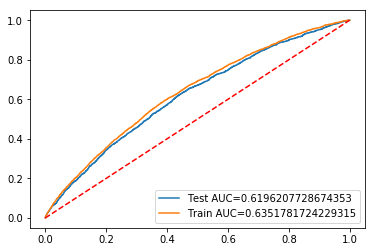

In [193]:
y_pred_proba_test = clf.predict_proba(x_test.drop(drops,axis=1))[::,1]
y_pred_proba_train = clf.predict_proba(x_train.drop(drops,axis=1))[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_train, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

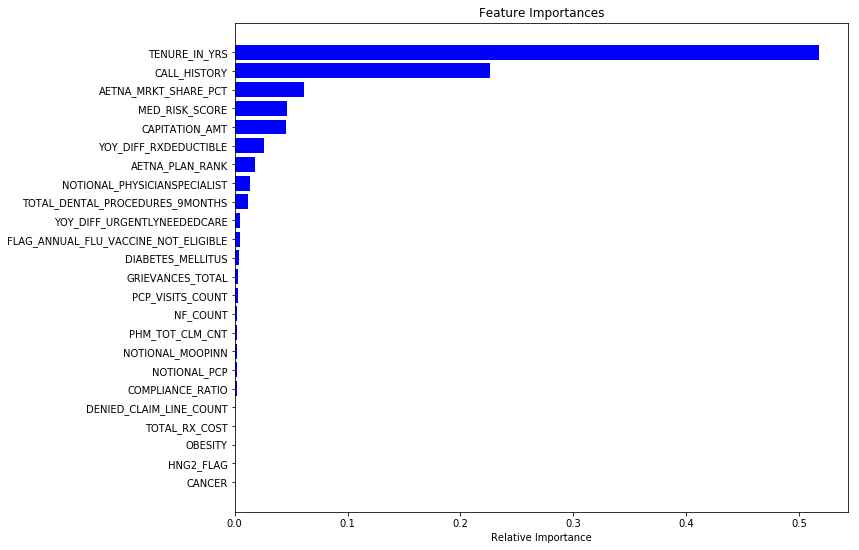

In [194]:
n =24
features = x_train.drop(drops,axis=1).columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(n), importances[indices][-n:], color='b', align='center')
plt.yticks(range(n), features[indices][-n:])
plt.xlabel('Relative Importance')
plt.show()

In [195]:
features[indices][-n:]

Index(['CANCER', 'HNG2_FLAG', 'OBESITY', 'TOTAL_RX_COST',
       'DENIED_CLAIM_LINE_COUNT', 'COMPLIANCE_RATIO', 'NOTIONAL_PCP',
       'NOTIONAL_MOOPINN', 'PHM_TOT_CLM_CNT', 'NF_COUNT', 'PCP_VISITS_COUNT',
       'GRIEVANCES_TOTAL', 'DIABETES_MELLITUS',
       'FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE', 'YOY_DIFF_URGENTLYNEEDEDCARE',
       'TOTAL_DENTAL_PROCEDURES_9MONTHS', 'NOTIONAL_PHYSICIANSPECIALIST',
       'AETNA_PLAN_RANK', 'YOY_DIFF_RXDEDUCTIBLE', 'CAPITATION_AMT',
       'MED_RISK_SCORE', 'AETNA_MRKT_SHARE_PCT', 'CALL_HISTORY',
       'TENURE_IN_YRS'],
      dtype='object')

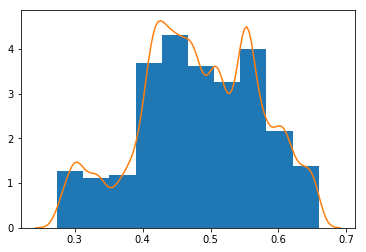

In [196]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

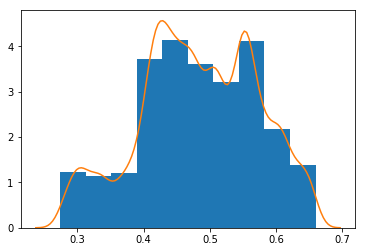

In [197]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [198]:
decile(clf,x_test.drop(drops,axis=1),y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,2088,433,2521,0.171757,0.171757,0.180417
2,2183,338,2521,0.134074,0.152916,0.321250
3,2233,288,2521,0.114240,0.140024,0.441250
4,2248,273,2521,0.108290,0.132090,0.555000
5,2268,252,2520,0.100000,0.125674,0.660000
6,2338,183,2521,0.072590,0.116826,0.736250
7,2308,213,2521,0.084490,0.112207,0.825000
8,2356,165,2521,0.065450,0.106362,0.893750
9,2387,134,2521,0.053154,0.100450,0.949583


### XGBoosting

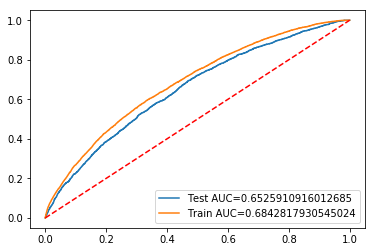

In [199]:
clf= XGBClassifier(random_state = 100,n_jobs=-1,max_depth=3,n_estimators = 100,learning_rate = 0.1,min_child_weight = 1)
clf.fit(x_train, y_train)
y_pred_proba_test = clf.predict_proba(x_test)[::,1]
y_pred_proba_train = clf.predict_proba(x_train)[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_train, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

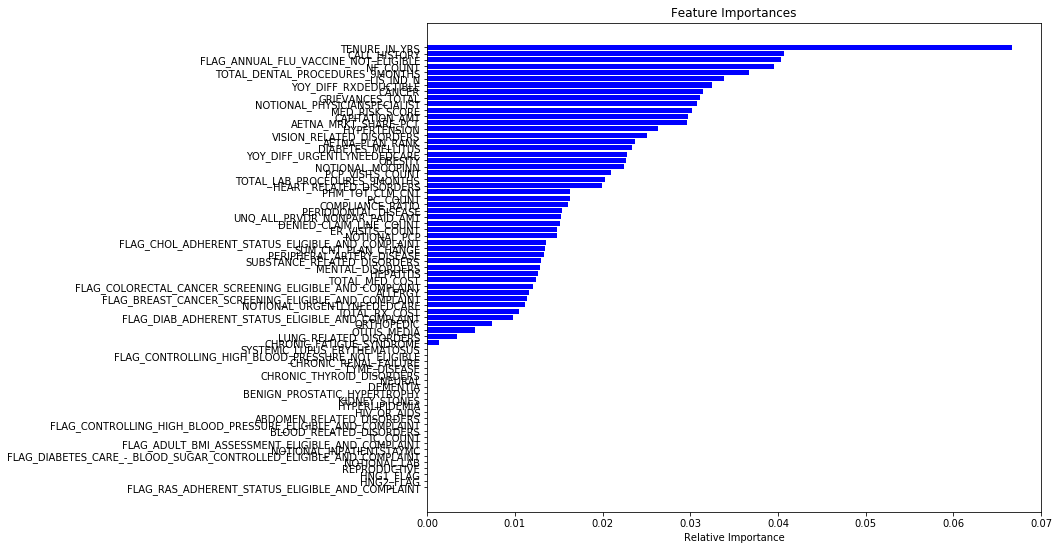

In [200]:
features = x_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(x_train.shape[1]), importances[indices][-x_train.shape[1]:], color='b', align='center')
plt.yticks(range(x_train.shape[1]), features[indices][-x_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()


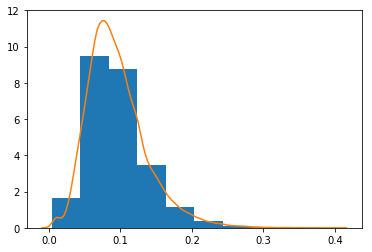

In [201]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

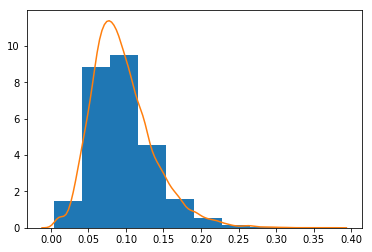

In [202]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [203]:
decile(clf,x_test,y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,2019,502,2521,0.199127,0.199127,0.209167
2,2147,374,2521,0.148354,0.173741,0.365000
3,2238,283,2521,0.112257,0.153246,0.482917
4,2261,260,2521,0.103134,0.140718,0.591250
5,2258,262,2520,0.103968,0.133370,0.700417
6,2324,197,2521,0.078144,0.124165,0.782500
7,2343,178,2521,0.070607,0.116514,0.856667
8,2395,126,2521,0.049980,0.108197,0.909167
9,2393,128,2521,0.050774,0.101816,0.962500


### Feature Importance

# SMOTE


In [204]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=100,n_jobs=-1,sampling_strategy=0.3)

In [205]:
X_os,y_os = smote.fit_resample(x_train,y_train)

In [206]:
pd.Series(y_os).value_counts()

0.0    53218
1.0    15965
Name: AEP2019_Lapse, dtype: int64

In [207]:
pd.Series(y_os).value_counts(normalize = True)

0.0    0.769235
1.0    0.230765
Name: AEP2019_Lapse, dtype: float64

### RandomForest using Oversampling

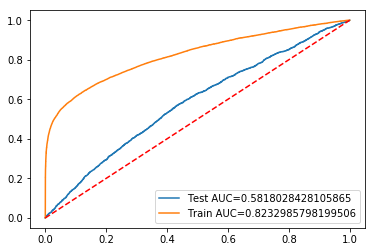

In [208]:
clf= RandomForestClassifier(random_state = 100,n_jobs=-1,max_depth=4,n_estimators = 180,
                            min_samples_split=100,max_leaf_nodes=5,class_weight='balanced')
clf.fit(X_os, y_os)
y_pred_proba_test = clf.predict_proba(x_test)[::,1]
y_pred_proba_train = clf.predict_proba(X_os)[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_os,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_os, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

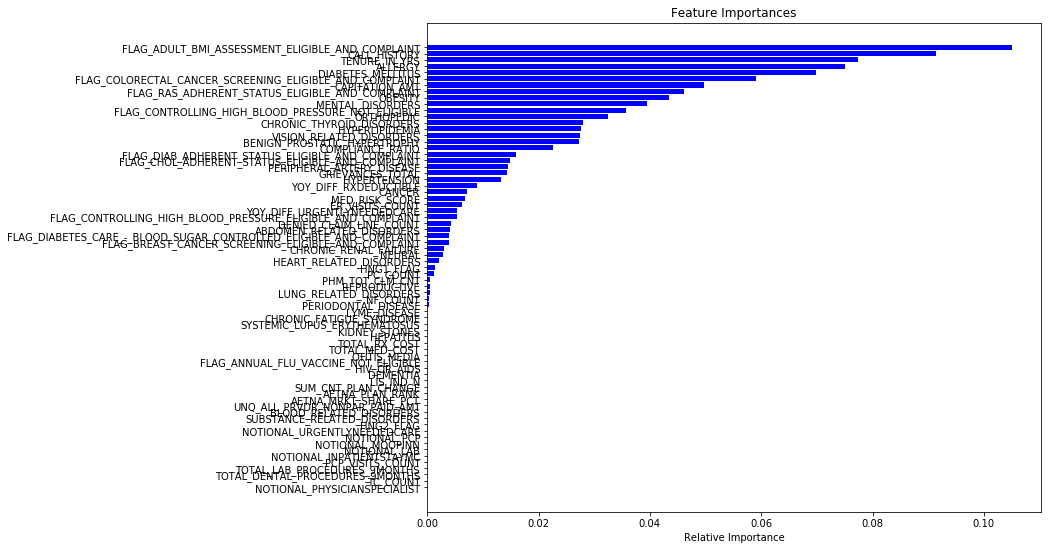

In [209]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(x_train.shape[1]), importances[indices][-x_train.shape[1]:], color='b', align='center')
plt.yticks(range(x_train.shape[1]), features[indices][-x_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()


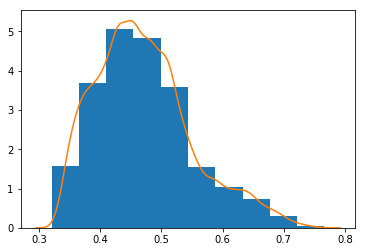

In [210]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

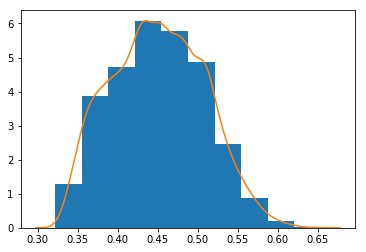

In [211]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [212]:
decile(clf,x_test,y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,2167,354,2521,0.140420,0.140420,0.147500
2,2190,331,2521,0.131297,0.135859,0.285417
3,2236,285,2521,0.113050,0.128256,0.404167
4,2248,273,2521,0.108290,0.123265,0.517917
5,2281,239,2520,0.094841,0.117582,0.617500
6,2323,198,2521,0.078540,0.111074,0.700000
7,2349,172,2521,0.068227,0.104953,0.771667
8,2337,184,2521,0.072987,0.100957,0.848333
9,2316,205,2521,0.081317,0.098775,0.933750


### XGBoost with oversampling

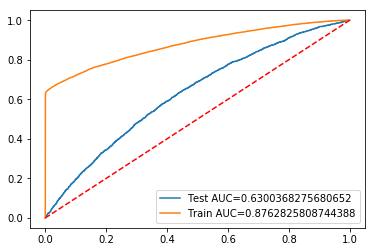

In [213]:
clf= XGBClassifier(random_state = 100,n_jobs=-1,max_depth=3,n_estimators = 100,learning_rate = 0.1,min_child_weight = 1)
clf.fit(pd.DataFrame(X_os,columns = x_test.columns), y_os)
y_pred_proba_test = clf.predict_proba(x_test)[::,1]
y_pred_proba_train = clf.predict_proba(pd.DataFrame(X_os,columns = x_test.columns))[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_os,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_os, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

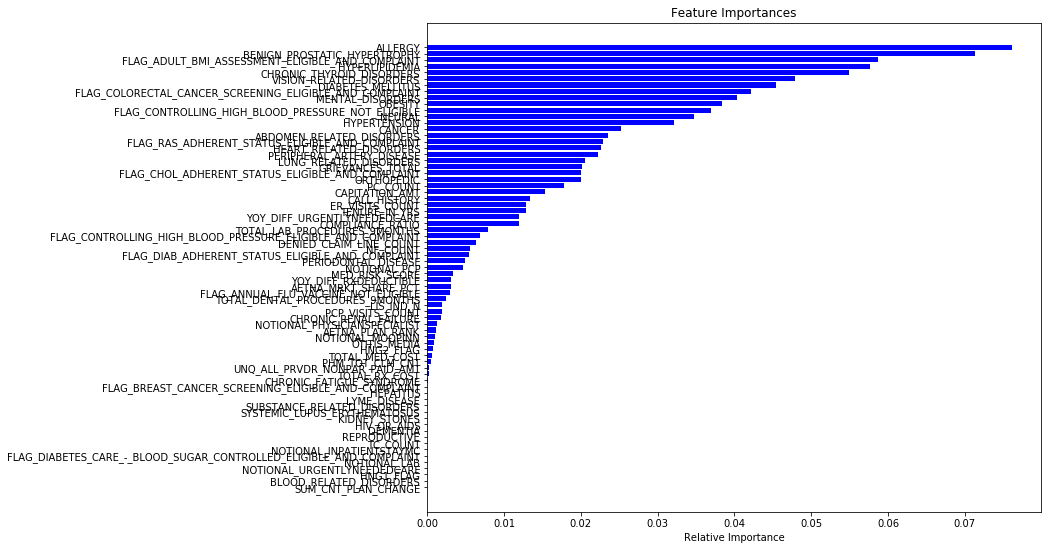

In [214]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(x_train.shape[1]), importances[indices][-x_train.shape[1]:], color='b', align='center')
plt.yticks(range(x_train.shape[1]), features[indices][-x_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()


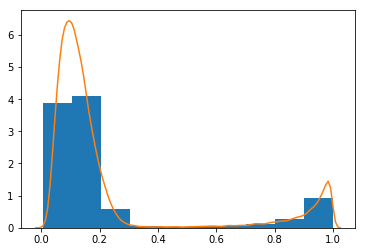

In [215]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

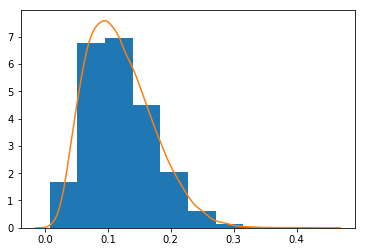

In [216]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [217]:
decile(clf,x_test,y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,2088,433,2521,0.171757,0.171757,0.180417
2,2163,358,2521,0.142007,0.156882,0.329583
3,2222,299,2521,0.118604,0.144123,0.454167
4,2236,285,2521,0.113050,0.136355,0.572917
5,2285,235,2520,0.093254,0.127737,0.670833
6,2310,211,2521,0.083697,0.120397,0.758750
7,2341,180,2521,0.071400,0.113397,0.833750
8,2361,160,2521,0.063467,0.107155,0.900417
9,2373,148,2521,0.058707,0.101772,0.962083


# Undersampling

In [218]:
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(random_state=100,sampling_strategy=0.35)
#RUS = ClusterCentroids(random_state=100,sampling_strategy='majority')

In [219]:
pd.Series(y_train).value_counts()

0.0    53218
1.0     5601
Name: AEP2019_Lapse, dtype: int64

In [220]:
X_us,y_us = RUS.fit_resample(x_train,y_train)

In [221]:
pd.Series(y_us).value_counts()

0.0    16002
1.0     5601
Name: AEP2019_Lapse, dtype: int64

In [222]:
pd.Series(y_us).value_counts(normalize=True)

0.0    0.74073
1.0    0.25927
Name: AEP2019_Lapse, dtype: float64

### RandomForest using Undersampling(Benchmarked)

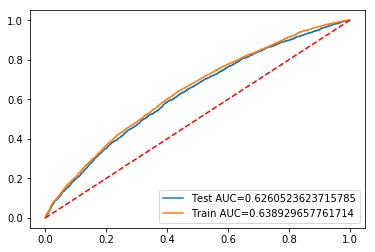

In [223]:
clf= RandomForestClassifier(random_state = 100,n_jobs=-1,max_depth=3,n_estimators = 100,min_samples_split=100,max_leaf_nodes=10,class_weight='balanced')
clf.fit(X_us, y_us)
y_pred_proba_test = clf.predict_proba(x_test)[::,1]
y_pred_proba_train = clf.predict_proba(X_us)[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_us,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_us, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

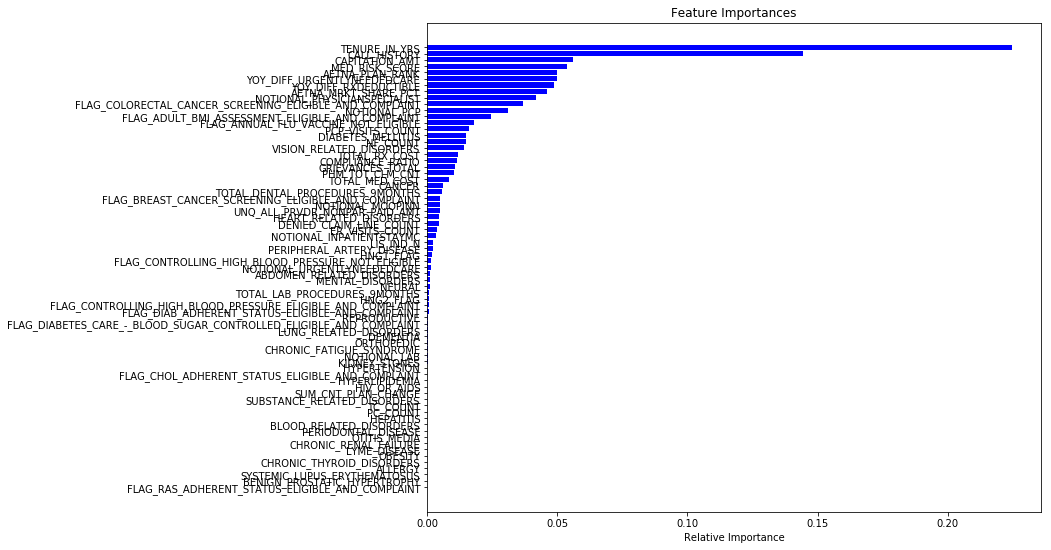

In [224]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(x_train.shape[1]), importances[indices][-x_train.shape[1]:], color='b', align='center')
plt.yticks(range(x_train.shape[1]), features[indices][-x_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()


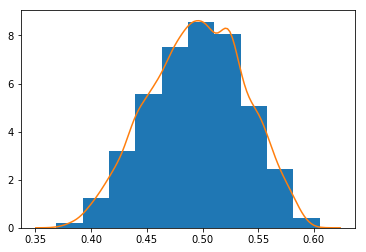

In [225]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

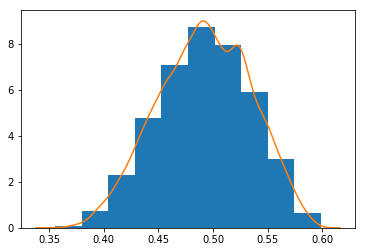

In [226]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [227]:
decile(clf,x_test,y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,2077,444,2521,0.176121,0.176121,0.185000
2,2162,359,2521,0.142404,0.159262,0.334583
3,2236,285,2521,0.113050,0.143858,0.453333
4,2261,260,2521,0.103134,0.133677,0.561667
5,2279,241,2520,0.095635,0.126071,0.662083
6,2313,208,2521,0.082507,0.118810,0.748750
7,2322,199,2521,0.078937,0.113113,0.831667
8,2369,152,2521,0.060294,0.106511,0.895000
9,2391,130,2521,0.051567,0.100406,0.949167


In [228]:
# from sklearn.externals import joblib
# filename = 'clf_finalized_model.sav'
# joblib.dump(clf, filename)

### XGBoosting using Undersampling Benchmarked

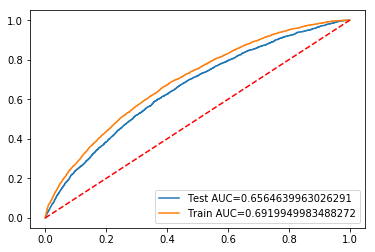

In [229]:
clf= XGBClassifier(random_state = 100,n_jobs=-1,max_depth=3,n_estimators = 100,learning_rate = 0.1,min_child_weight = 1)
clf.fit(pd.DataFrame(X_us,columns = x_test.columns), y_us)
y_pred_proba_test = clf.predict_proba(x_test)[::,1]
y_pred_proba_train = clf.predict_proba(pd.DataFrame(X_us,columns = x_test.columns))[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_us,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_us, y_pred_proba_train)
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

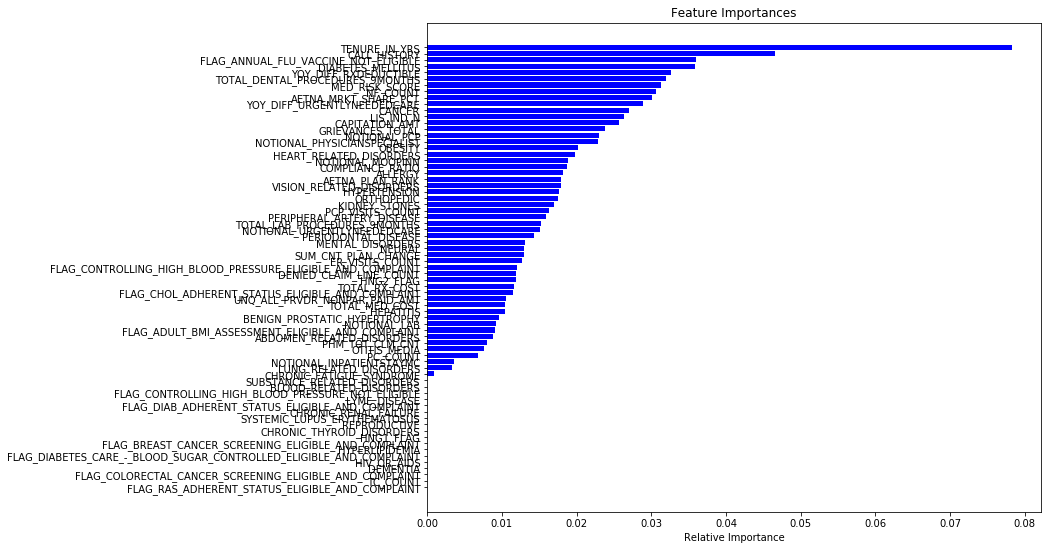

In [230]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(11,9))
plt.title('Feature Importances')
plt.barh(range(x_train.shape[1]), importances[indices][-x_train.shape[1]:], color='b', align='center')
plt.yticks(range(x_train.shape[1]), features[indices][-x_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()


In [231]:
features[indices][-30:]

Index(['NOTIONAL_URGENTLYNEEDEDCARE', 'TOTAL_LAB_PROCEDURES_9MONTHS',
       'PERIPHERAL_ARTERY_DISEASE', 'PCP_VISITS_COUNT', 'KIDNEY_STONES',
       'ORTHOPEDIC', 'HYPERTENSION', 'VISION_RELATED_DISORDERS',
       'AETNA_PLAN_RANK', 'ALLERGY', 'COMPLIANCE_RATIO', 'NOTIONAL_MOOPINN',
       'HEART_RELATED_DISORDERS', 'OBESITY', 'NOTIONAL_PHYSICIANSPECIALIST',
       'NOTIONAL_PCP', 'GRIEVANCES_TOTAL', 'CAPITATION_AMT', 'LIS_IND_N',
       'CANCER', 'YOY_DIFF_URGENTLYNEEDEDCARE', 'AETNA_MRKT_SHARE_PCT',
       'NF_COUNT', 'MED_RISK_SCORE', 'TOTAL_DENTAL_PROCEDURES_9MONTHS',
       'YOY_DIFF_RXDEDUCTIBLE', 'DIABETES_MELLITUS',
       'FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE', 'CALL_HISTORY',
       'TENURE_IN_YRS'],
      dtype='object')

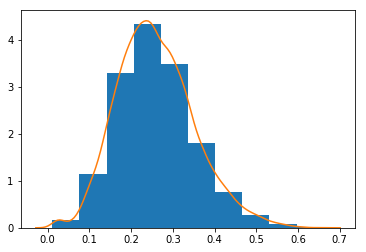

In [232]:
plt.hist(y_pred_proba_train,normed=True)
sns.kdeplot(y_pred_proba_train)

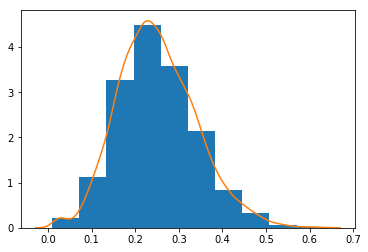

In [233]:
plt.hist(y_pred_proba_test,normed=True)
sns.kdeplot(y_pred_proba_test)

In [234]:
decile(clf,x_test,y_test)

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Deciles,,,,,,
1,1995,526,2521,0.208647,0.208647,0.219167
2,2180,341,2521,0.135264,0.171956,0.361250
3,2204,317,2521,0.125744,0.156552,0.493333
4,2251,270,2521,0.107100,0.144189,0.605833
5,2288,232,2520,0.092063,0.133767,0.702500
6,2329,192,2521,0.076160,0.124165,0.782500
7,2351,170,2521,0.067434,0.116060,0.853333
8,2368,153,2521,0.060690,0.109139,0.917083
9,2409,112,2521,0.044427,0.101948,0.963750


In [235]:
### using the stable model
(pd.DataFrame(clf.feature_importances_,index=x_test.columns,columns=['Importance'])
.sort_values(by='Importance',ascending=False)
#  .head(30)
.to_csv('//mbip/medicarepBI/Projects/COE/Cognizant Team Folder/Jereamy/Wk3/01-31-20/Texas_Feature_importance_XGBOOST_US.csv')
)


In [236]:
#from cognilearn.metrics import specificity_vs_sensitivity as svs
#svs(clf,x_test,y_test,pd.DataFrame(X_us,columns = x_test.columns),y_us,)

# Prediction

In [237]:
# from sklearn.externals import joblib
# # Load from file
# filename = '//mbip/medicarepBI/Projects/COE/Retention/Deliverables/Refreshed Models AEP/Texas/Code/clf_finalized_model.sav'
# # joblib_file = "rf_2018_model.pkl"
# clf = joblib.load(filename)
# clf

In [238]:
D2019 = pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Deliverables/Refreshed Models AEP/Texas/Base/Texas_for_prediction_2019_D24JAN2020.csv'
                    ,engine='c'
                    ,dtype={'SRC_MEMBER_ID':str,'INDIVIDUAL_ID':str})

In [239]:
D2019.head(1)

,SRC_MEMBER_ID,INDIVIDUAL_ID,DENIED_CLAIM_LINE_COUNT,CALL_HISTORY,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,IP_VISITS_COUNT,PHM_TOT_CLM_CNT,MED_TOT_CLM_CNT,TENURE_IN_YRS,DISTINCT_GPI,TOTAL_MED_COST,AGEINYRS,CAPITATION_AMT,MED_RISK_SCORE,TOTAL_RX_COST,UNQ_ALL_PRVDR_PAR_CLAIM_COUNT,UNQ_ALL_PRVDR_NONPAR_CLAIM_COUNT,SPCLST_TRANSACTIONS,UNQ_ALL_PRVDR_PAR_PAID_AMT,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,MEMBER_SUMMARY,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,HNG1_FLAG,HNG2_FLAG,CANCER,MENTAL_DISORDERS,NEURAL,REPRODUCTIVE,SUBSTANCE_RELATED_DISORDERS,VISION_RELATED_DISORDERS,ORTHOPEDIC,LUNG_RELATED_DISORDERS,HEART_RELATED_DISORDERS,BLOOD_RELATED_DISORDERS,ABDOMEN_RELATED_DISORDERS,YOY_DIFF_URGENTLYNEEDEDCARE,YOY_DIFF_RXDEDUCTIBLE,NOTIONAL_INPATIENTSTAYMC,NOTIONAL_PHYSICIANSPECIALIST,NOTIONAL_LAB,NOTIONAL_MOOPINN,NOTIONAL_PCP,NOTIONAL_EMERGENCY,NOTIONAL_URGENTLYNEEDEDCARE,NOTIONAL_RXDEDUCTIBLE,COMPLIANCE_RATIO,GRIEVANCES_TOTAL,TC_COUNT,NF_COUNT,PC_COUNT,FIPS,COMPETITOR_CNT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,SUM_CNT_PLAN_CHANGE,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE_AND_COMPLAINT,FLAG_ADULT_BMI_ASSESSMENT_NOT_ELIGIBLE,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE,FLAG_ANNUAL_FLU_VACCINE_ELIGIBLE_AND_COMPLAINT,FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE,FLAG_ANNUAL_FLU_VACCINE_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_BREAST_CANCER_SCREENING_NOT_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_CHOL_ADHERENT_STATUS_NOT_ELIGIBLE,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE,FLAG_CARE_FOR_OLDER_ADULTS_-_FUNCTIONAL_STATUS_ASSESSMENT_NOT_ELIGIBLE,FLAG_CARE_FOR_OLDER_ADULTS_-_MEDICATION_REVIEW_NOT_ELIGIBLE,FLAG_CARE_FOR_OLDER_ADULTS_-_PAIN_SCREENING_NOT_ELIGIBLE,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_COLORECTAL_CANCER_SCREENING_NOT_ELIGIBLE,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_NOT_ELIGIBLE,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_DIAB_ADHERENT_STATUS_NOT_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_NOT_ELIGIBLE,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE,FLAG_DIABETES_CARE_-_EYE_EXAMS_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_EYE_EXAMS_NOT_ELIGIBLE,FLAG_DIABETES_CARE_-_EYE_EXAMS_ELIGIBLE,FLAG_DIABETES_CARE_-_KIDNEY_DISEASE_MONITORING_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_KIDNEY_DISEASE_MONITORING_NOT_ELIGIBLE,FLAG_DIABETES_CARE_-_KIDNEY_DISEASE_MONITORING_ELIGIBLE,FLAG_MEDICATION_RECONCILIATION_POST_DISCHARGE_ELIGIBLE_AND_COMPLAINT,FLAG_MEDICATION_RECONCILIATION_POST_DISCHARGE_NOT_ELIGIBLE,FLAG_MEDICATION_RECONCILIATION_POST_DISCHARGE_ELIGIBLE,FLAG_OSTEOPOROSIS_MANAGEMENT_IN_WOMEN_WHO_HAD_A_FRACTURE_ELIGIBLE_AND_COMPLAINT,FLAG_OSTEOPOROSIS_MANAGEMENT_IN_WOMEN_WHO_HAD_A_FRACTURE_NOT_ELIGIBLE,FLAG_OSTEOPOROSIS_MANAGEMENT_IN_WOMEN_WHO_HAD_A_FRACTURE_ELIGIBLE,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_RAS_ADHERENT_STATUS_NOT_ELIGIBLE,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE,FLAG_RHEUMATOID_ARTHRITIS_MANAGEMENT_ELIGIBLE_AND_COMPLAINT,FLAG_RHEUMATOID_ARTHRITIS_MANAGEMENT_NOT_ELIGIBLE,FLAG_RHEUMATOID_ARTHRITIS_MANAGEMENT_ELIGIBLE,LIS_IND_N,LIS_IND_Y
0,MEBSNBZM,445400911125075,0.0,8.0,0.0,0.0,3.0,0.0,0.0,4.0,7.0,0.0,2.0,273.88,66.0,4.83,0.466,20.27,2.0,0.0,2.0,209.78,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48201.0,11.0,10.403562,13.0,0.0,0,1,0,0,0,1,

In [240]:
D2019.drop(['TENURE_IN_YRS'],axis=1,inplace=True)

In [241]:
base_tenure = pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Ting/Data Dump 20200129/AEP_2020_DataDump.csv',usecols = ['Tenure_Aetna_Mths','Member_ID']).rename({'Tenure_Aetna_Mths':'TENURE_IN_YRS','Member_ID':'SRC_MEMBER_ID'},axis=1)
base_tenure.SRC_MEMBER_ID=base_tenure.SRC_MEMBER_ID.astype(str)
base_tenure.SRC_MEMBER_ID  =  base_tenure.SRC_MEMBER_ID.str.split('*').str.join('').str.strip()

In [242]:
D2019 = D2019.merge(base_tenure,on='SRC_MEMBER_ID',how='left')
D2019.TENURE_IN_YRS = D2019.TENURE_IN_YRS.fillna(D2019.TENURE_IN_YRS.mean())
D2019.TENURE_IN_YRS.isnull().sum()

0

In [243]:
#D2019.TENURE_IN_YRS = (D2019.TENURE_IN_YRS+1)/12
#D2019['TENURE_IN_YRS'] = np.clip(D2019['TENURE_IN_YRS'], a_max=12, a_min=None)
D2019.set_index(['SRC_MEMBER_ID','INDIVIDUAL_ID'],inplace=True)

In [244]:
pred = D2019[x_train.columns]

In [245]:
pred.head(2)

,,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,CALL_HISTORY,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,NF_COUNT,PC_COUNT,TC_COUNT,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,PHM_TOT_CLM_CNT,YOY_DIFF_URGENTLYNEEDEDCARE,YOY_DIFF_RXDEDUCTIBLE,NOTIONAL_INPATIENTSTAYMC,NOTIONAL_PHYSICIANSPECIALIST,NOTIONAL_LAB,NOTIONAL_MOOPINN,NOTIONAL_PCP,NOTIONAL_URGENTLYNEEDEDCARE,HNG1_FLAG,HNG2_FLAG,CANCER,MENTAL_DISORDERS,NEURAL,REPRODUCTIVE,SUBSTANCE_RELATED_DISORDERS,VISION_RELATED_DISORDERS,ORTHOPEDIC,LUNG_RELATED_DISORDERS,HEART_RELATED_DISORDERS,BLOOD_RELATED_DISORDERS,ABDOMEN_RELATED_DISORDERS,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,SUM_CNT_PLAN_CHANGE,TENURE_IN_YRS,GRIEVANCES_TOTAL,COMPLIANCE_RATIO,LIS_IND_N,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE_AND_COMPLAINT,FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_NOT_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE_AND_COMPLAINT,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT
SRC_MEMBER_ID,INDIVIDUAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEBSNBZM,445400911125075,4.83,0.0,0.466,273.88,20.27,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.00,10.403562,13.0,0.0,8.0,0.0,0.00,1,0,0,0,0,0,0,1,0,0,0
MEBP8WTX,455276152331044,6.90,3.0,0.482,838.70,23.54,17.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239.32,8.384365,11.0,0.0,18.0,0.0,0.75,1,0,0,0,1,0,0,0,0,0,1


In [ ]:
# pred.TENURE_IN_YRS =  np.where( pred.TENURE_IN_YRS-1 > 0, pred.TENURE_IN_YRS-1, 0  )
# pred.TENURE_IN_YRS.value_counts()

In [ ]:
# pred.TENURE_IN_YRS =  np.where( pred.TENURE_IN_YRS > 3,3, pred.TENURE_IN_YRS  )
# pred.TENURE_IN_YRS.value_counts()

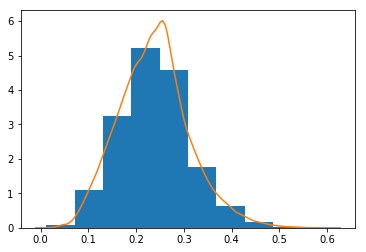

In [246]:
plt.hist(clf.predict_proba(pred)[::,1],normed=1)
sns.kdeplot(clf.predict_proba(pred)[::,1])

In [247]:
pred['PROPENSITY'] = clf.predict_proba(pred)[::,1]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [248]:
#Deciles for 2019 population
pred['Decile'] = pd.qcut(pred['PROPENSITY'].rank(method='first'),10,labels = np.arange(10,0,-1))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [249]:
pred.groupby('Decile').PROPENSITY.agg(['max','min','mean'])

,max,min,mean
Decile,,,
10,0.142968,0.011430,0.114636
9,0.174258,0.142968,0.159594
8,0.197596,0.174258,0.186356
7,0.218074,0.197597,0.207922
6,0.236214,0.218080,0.227401
5,0.253542,0.236215,0.245025
4,0.270357,0.253546,0.261646
3,0.293345,0.270357,0.281119
2,0.331573,0.293346,0.310591


In [250]:
pred.head(2)

,,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,CALL_HISTORY,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,NF_COUNT,PC_COUNT,TC_COUNT,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,PHM_TOT_CLM_CNT,YOY_DIFF_URGENTLYNEEDEDCARE,YOY_DIFF_RXDEDUCTIBLE,NOTIONAL_INPATIENTSTAYMC,NOTIONAL_PHYSICIANSPECIALIST,NOTIONAL_LAB,NOTIONAL_MOOPINN,NOTIONAL_PCP,NOTIONAL_URGENTLYNEEDEDCARE,HNG1_FLAG,HNG2_FLAG,CANCER,MENTAL_DISORDERS,NEURAL,REPRODUCTIVE,SUBSTANCE_RELATED_DISORDERS,VISION_RELATED_DISORDERS,ORTHOPEDIC,LUNG_RELATED_DISORDERS,HEART_RELATED_DISORDERS,BLOOD_RELATED_DISORDERS,ABDOMEN_RELATED_DISORDERS,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,SUM_CNT_PLAN_CHANGE,TENURE_IN_YRS,GRIEVANCES_TOTAL,COMPLIANCE_RATIO,LIS_IND_N,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE_AND_COMPLAINT,FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_NOT_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE_AND_COMPLAINT,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,PROPENSITY,Decile
SRC_MEMBER_ID,INDIVIDUAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEBSNBZM,445400911125075,4.83,0.0,0.466,273.88,20.27,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.00,10.403562,13.0,0.0,8.0,0.0,0.00,1,0,0,0,0,0,0,1,0,0,0,0.263645,4
MEBP8WTX,455276152331044,6.90,3.0,0.482,838.70,23.54,17.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239.32,8.384365,11.0,0.0,18.0,0.0,0.75,1,0,0,0,1,0,0,0,0,0,1,0.180926,8


In [251]:
import gc
gc.collect()

249

In [252]:
pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Ting/Data Dump 20191219/AEP_2020_DataDump.csv',nrows=1)

,AEP2020_Denom,AEP2020_Lapse,OEP2020_Overall_Denom,NEW_MARKET,MA_Market_PDP_Product,SNP,LIS_Flag,Movement_Type_In,Movement_Type_Out,Enroll_Status,Exit_Status,DRC_Term_Status,MEDICARE_NUMBER,Member_ID,EFF_Date,Term_Date,Contract_Number,PBP,Source_System,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Issued_Status,Group_Status,BatchID,Brand,Product,CMS_County,CMS_State,MA_Region,NEW_REGION,MA_Territory,PDP_CMS_Region,DOB,Age,Gender,DRC_Term_Code,DRC_Term_Reason,Year_Eff,Month_Eff,Quarter_Eff,Plan_Name,Plan_Type,RX_Ind,Aetna_ID,Run_Date,Ap_Received_Date,Address1,Address2,City,State,ZIP,FIPS,MEM_Phone,BrokerTIN,Broker_NPN,Writing_Agent_ID,Writing_Agent_Name,TOH_Name,TOH_ID,Sales_Channel,Historic_Sales_Channel,Prior_System_Source,Prior_HCFA_Contract,Prior_PBP,Prior_AWN,Prior_Writing_Agent_Name,Prior_Brand,DP_NAME,DP_ID,PMO_NAME,PMO_ID,NMO_NAME,NMO_ID,RMO_NAME,RMO_ID,MMO_NAME,MMO_ID,GMO_NAME,GMO_ID,LMO_NAME,LMO_ID,Recruiter_Name,Recruiter_ID,Dual_Status,HVN,TAT_Broker_Received_Date,TAT_Company_Received_Date,Turn_Around_Time_Days,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,Emp_Plan_Sponsor,AppType,AppSource,SSI_Level_2_ID,SSI_Level_2_Name,SSI_Client_Code,ATN_Affinity,BrokerManagerName,TRR_Entity_Name,TRR_Organization_Name,TRR_Parent_Name,Mth_Eff,Period_Eff,Period_Term,Period_App,Mbr_Mths,BEQ_Prior_Contract,BEQ_Prior_PBP,BEQ_Prior_Organization,TRR_Next_Contract,TRR_Transaction_Date,beq_Transaction_Date,LIVES_CNT,CMS_NEW
0,1,0,1,NYNJ,NYNJ,NaN,NaN,New_Sale,Active,Active,Active,NaN,6RM8AN2CV34,MEBNKSSJ,01OCT2017,31DEC9999,H5521,120,HMOe,PATRICIA,TIRRO,NaN,Issued,Individual,6419241,AET,MA,ROCKLAND,NY,NORTHEAST,NORTHEAST,NY_ROCKLAND_WESTCHESTER,NaN,20AUG1952,67,F,NaN,NaN,2017,October,Q4,Aetna Medicare Elite Plan (PPO),PPO,NaN,NaN,20191218,21SEP2017,174 ORANGE AVE APT 2N,NaN,SUFFOLK,NY,109011440,36087,8458935792,74767777,9719598,122986,"Marrujo, Rosamaria","Amerilife Agencies,",999991,NDP,Broker_Related,NaN,NaN,NaN,NaN,NaN,AET,"Amerilife Agencies,",999991,"Network Insurance Senior Health Division ALG, LLC",104374,NaN,NaN,NaN,NaN,NaN,NaN,"TRUSTED AMERICAN INSURANCE AGENCY, INC.",217609,NaN,NaN,"TRUSTED AMERICAN INSURANCE AGENCY, INC.",217609,NaN,NaN,21SEP2017,22SEP2017,1,Bon Secours Charity Health System Medical Grou...,223636986,NE IND PPO,354635,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aetna,Robert Rothschild,NaN,NaN,NaN,10,201710,999912,201709,27,NaN,NaN,NaN,NaN,NaN,09/26/2017,NaN,NaN


In [253]:
base_david = pd.read_csv('//mbip/medicarepBI/Projects/COE/Retention/Data/Ting/Data Dump 20200129/AEP_2020_DataDump.csv'
                          ,skipinitialspace=True,usecols= ['AEP2020_Lapse','Member_ID'],
                          encoding='ISO-8859-1').rename(columns = {'Member_ID':'SRC_MEMBER_ID'})


#proessing source member id 
base_david.SRC_MEMBER_ID=base_david.SRC_MEMBER_ID.astype(str)
base_david.SRC_MEMBER_ID=base_david.SRC_MEMBER_ID.str.split('*').str.join('').str.strip()
base_david.SRC_MEMBER_ID = base_david.SRC_MEMBER_ID.str.strip()

# dropping duplicate members
base_david.drop_duplicates(inplace=True)
base_david.head(1)

,AEP2020_Lapse,SRC_MEMBER_ID
0,0,762053557012


In [254]:
pred.reset_index(inplace=True)
pred.SRC_MEMBER_ID = pred.SRC_MEMBER_ID.astype(str)
base_david.SRC_MEMBER_ID = base_david.SRC_MEMBER_ID.astype(str)

C:\Users\n432209\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [255]:
validation_df = pd.merge(pred[['SRC_MEMBER_ID','PROPENSITY','Decile']],base_david,on='SRC_MEMBER_ID',how='inner')
print(validation_df.SRC_MEMBER_ID.nunique(),validation_df.shape)
validation_df.head(1)

110417 (110417, 4)


,SRC_MEMBER_ID,PROPENSITY,Decile,AEP2020_Lapse
0,MEBSNBZM,0.263645,4,0


In [256]:
k = validation_df.groupby(['Decile','AEP2020_Lapse']).size().unstack().fillna(0).rename(columns= {0:'Zero',1:'Ones'})
k['Population'] = k['Ones']+k['Zero']
summary=k.sort_index(ascending=False)
summary['TargetRate']=summary['Ones']/summary['Population']
summary['CumulativeTargetRate']=summary['Ones'].cumsum()/summary['Population'].cumsum()
summary['TargetsCaptured']=summary['Ones'].cumsum()/summary['Ones'].sum()
summary

AEP2020_Lapse,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured
Decile,,,,,,
1,9980,1063,11043,0.096260,0.096260,0.221228
2,10374,667,11041,0.060411,0.078337,0.360042
3,10518,524,11042,0.047455,0.068043,0.469095
4,10531,511,11042,0.046278,0.062602,0.575442
5,10611,431,11042,0.039033,0.057888,0.665140
6,10655,388,11043,0.035135,0.054096,0.745890
7,10661,378,11039,0.034242,0.051260,0.824558
8,10705,336,11041,0.030432,0.048657,0.894485
9,10752,290,11042,0.026263,0.046169,0.954839


In [257]:
validation_df_full = pd.merge(pred,base_david,on='SRC_MEMBER_ID',how='inner')

In [258]:
validation_df_full['Decile_Category'] = pd.cut(validation_df_full.Decile, [0,3, 7,np.inf], labels=['High','Medium','Low'])

In [259]:
validation_df_full.head(2)

,SRC_MEMBER_ID,INDIVIDUAL_ID,CAPITATION_AMT,DENIED_CLAIM_LINE_COUNT,MED_RISK_SCORE,TOTAL_MED_COST,TOTAL_RX_COST,CALL_HISTORY,HEPATITIS,CHRONIC_FATIGUE_SYNDROME,PERIPHERAL_ARTERY_DISEASE,PERIODONTAL_DISEASE,CHRONIC_RENAL_FAILURE,LYME_DISEASE,OBESITY,CHRONIC_THYROID_DISORDERS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,BENIGN_PROSTATIC_HYPERTROPHY,KIDNEY_STONES,HYPERLIPIDEMIA,OTITIS_MEDIA,HYPERTENSION,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS,NF_COUNT,PC_COUNT,TC_COUNT,TOTAL_DENTAL_PROCEDURES_9MONTHS,TOTAL_LAB_PROCEDURES_9MONTHS,PCP_VISITS_COUNT,ER_VISITS_COUNT,PHM_TOT_CLM_CNT,YOY_DIFF_URGENTLYNEEDEDCARE,YOY_DIFF_RXDEDUCTIBLE,NOTIONAL_INPATIENTSTAYMC,NOTIONAL_PHYSICIANSPECIALIST,NOTIONAL_LAB,NOTIONAL_MOOPINN,NOTIONAL_PCP,NOTIONAL_URGENTLYNEEDEDCARE,HNG1_FLAG,HNG2_FLAG,CANCER,MENTAL_DISORDERS,NEURAL,REPRODUCTIVE,SUBSTANCE_RELATED_DISORDERS,VISION_RELATED_DISORDERS,ORTHOPEDIC,LUNG_RELATED_DISORDERS,HEART_RELATED_DISORDERS,BLOOD_RELATED_DISORDERS,ABDOMEN_RELATED_DISORDERS,UNQ_ALL_PRVDR_NONPAR_PAID_AMT,AETNA_MRKT_SHARE_PCT,AETNA_PLAN_RANK,SUM_CNT_PLAN_CHANGE,TENURE_IN_YRS,GRIEVANCES_TOTAL,COMPLIANCE_RATIO,LIS_IND_N,FLAG_ADULT_BMI_ASSESSMENT_ELIGIBLE_AND_COMPLAINT,FLAG_ANNUAL_FLU_VACCINE_NOT_ELIGIBLE,FLAG_BREAST_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CHOL_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_COLORECTAL_CANCER_SCREENING_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_ELIGIBLE_AND_COMPLAINT,FLAG_CONTROLLING_HIGH_BLOOD_PRESSURE_NOT_ELIGIBLE,FLAG_DIAB_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,FLAG_DIABETES_CARE_-_BLOOD_SUGAR_CONTROLLED_ELIGIBLE_AND_COMPLAINT,FLAG_RAS_ADHERENT_STATUS_ELIGIBLE_AND_COMPLAINT,PROPENSITY,Decile,AEP2020_Lapse,Decile_Category
0,MEBSNBZM,445400911125075,4.83,0.0,0.466,273.88,20.27,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.00,10.403562,13.0,0.0,8.0,0.0,0.00,1,0,0,0,0,0,0,1,0,0,0,0.263645,4,0,Medium
1,MEBP8WTX,455276152331044,6.90,3.0,0.482,838.70,23.54,17.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239.32,8.384365,11.0,0.0,18.0,0.0,0.75,1,0,0,0,1,0,0,0,0,0,1,0.180926,8,0,Low


In [260]:
pred.to_csv('//mbip/medicarepBI/Projects/COE/Cognizant Team Folder/Jereamy/Wk3/01-31-20/Predicted_propensity_Texas_2019prediction_JR_31JAN2020.csv')

In [261]:
validation_df_full.to_csv('//mbip/medicarepBI/Projects/COE/Cognizant Team Folder/Jereamy/Wk3/01-31-20/Texas_2019_Prediction_full_Validation_JR_31JAN2020.csv')